In [ ]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


Gefitte energie: 2.500 MeV, Massa elektron: 1.000e+00 kg


C:\Users\maria\AppData\Local\Temp\ipykernel_28500\3852206492.py:11: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(compton, theta_data, energy_data, sigma=energy_error)


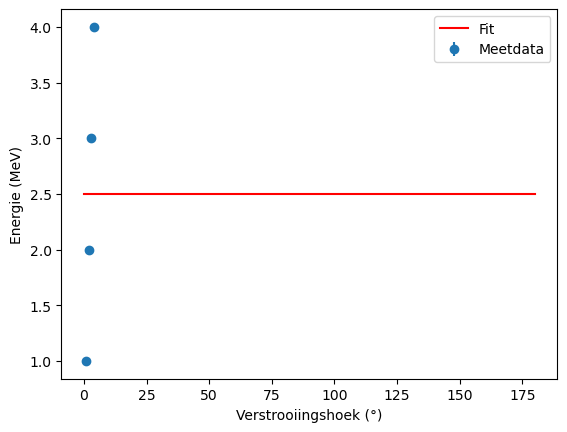

In [ ]:
# compton scattering functie
def compton(theta, E, me):
    return E / (1 + (E / (me * 3e8 **2)) * (1 - np.cos(np.radians(theta))))


theta_data = np.array([])  # hoek in graden
energy_data = np.array([1, 2, 3, 4])  # energie in MeV
energy_error = np.array([0.01, 0.01, 0.01, 0.01])  # onzekerheid

# curve fit gedoe
popt, pcov = curve_fit(compton, theta_data, energy_data, sigma=energy_error)
E_fit, me_fit = popt  # gefitte parameters
print(f"Gefitte energie: {E_fit:.3f} MeV, Massa elektron: {me_fit:.3e} kg")

# plot
theta_fit = np.linspace(0, 180, 500)
energy_fit = compton(theta_fit, *popt)
plt.errorbar(theta_data, energy_data, yerr=energy_error, fmt='o', label='Meetdata')
plt.plot(theta_fit, energy_fit, label='Fit', color='red')
plt.xlabel('Scattering (°)')
plt.ylabel('Energie (MeV)')
plt.legend()
plt.show()

In [ ]:
def energy_error_theta(theta, E, me, sigma_theta):
    factor = (E / (me * 3e8**2)) * np.sin(np.radians(theta))
    nom = (1 + (E / (me * 3e8**2)) * (1 - np.cos(np.radians(theta))))**2
    dE_dtheta = E * factor / nom
    return np.abs(dE_dtheta) * sigma_theta

sigma_theta_contribution = energy_error_theta(theta_data, 0.662, 9.11e-31, sigma_theta_rad)

sigma_total = np.sqrt(sigma_detector**2 + sigma_statistical**2 + sigma_calibration**2 + sigma_theta_contribution**2) #alle fouten nog erbij doen


In [ ]:
import pandas as pd


input_files = ['theta1_6dec_spectrum', 'theta1_6dec_spectrum2']
output_files = ['theta1_6dec_spectrum.csv', 'theta1_6dec_spectrum2.csv']


dfs = []

for input_file, output_file in zip(input_files, output_files):
    with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
        for line in infile:
            values = line.strip().split()
            outfile.write(','.join(values) + '\n')

 
    df = pd.read_csv(output_file, sep=',', header=None)
    df = df.iloc[1:].reset_index(drop=True)  
    df = df.apply(pd.to_numeric, errors='coerce')  # numeriek maken
    dfs.append(df)


combined_df = dfs[0].copy()
combined_df.iloc[:, 1] = sum(df.iloc[:, 1] for df in dfs)


combined_output_file = 'combined_spectrum.csv'
combined_df.to_csv(combined_output_file, index=False, header=False)



In [8]:
pulseheight_compton_cesium = combined_df.iloc[:, 0].values  
counts_compton_cesium = combined_df.iloc[:, 1].values   


C:\Users\maria\AppData\Local\Temp\ipykernel_20612\766162025.py:33: OptimizeWarning: Covariance of the parameters could not be estimated
  params, covariance = curve_fit(


Fitted Parameters:
Amplitude: 31.00 ± inf
Center (Pulse hoogte op de piek): 312.06 ± inf mV
Width (sigma): 50.00 ± inf mV
FWHM: 117.74 mV
Resolutie: 37.73%


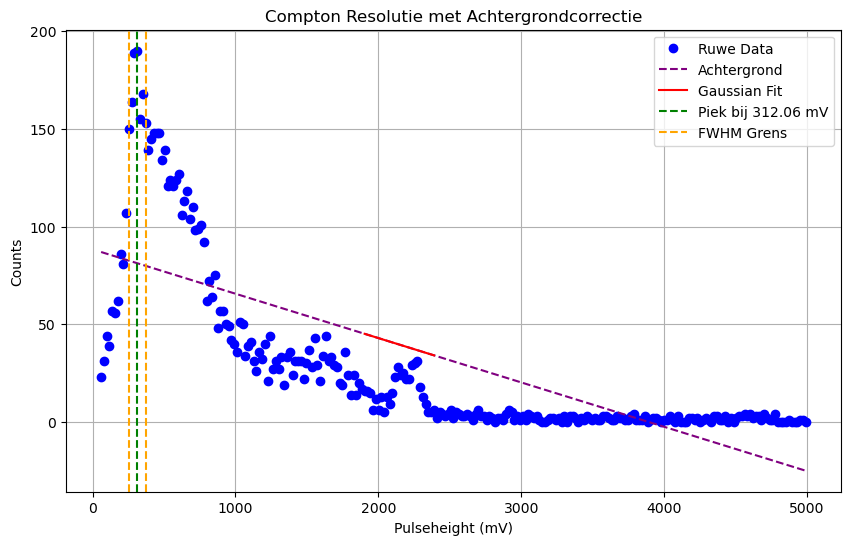

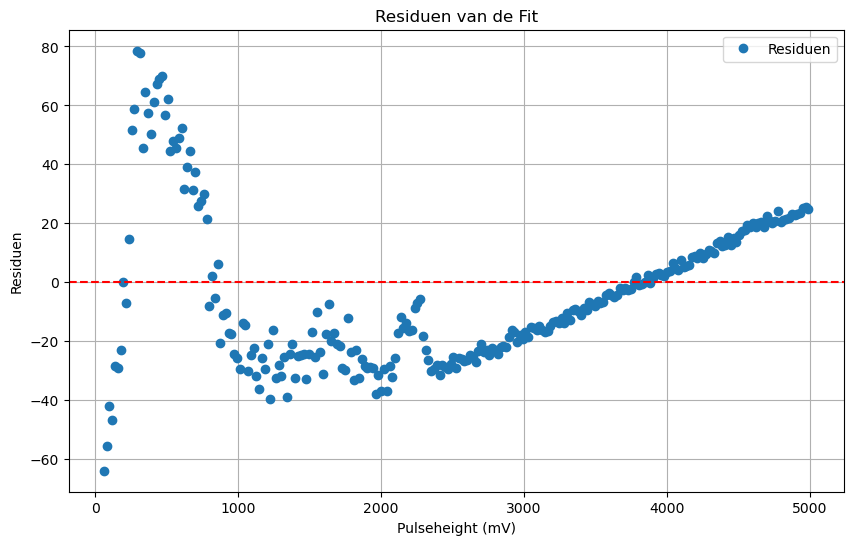

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Gaussische functie
def gauss_function(x, amp, cen, width):
    return amp * np.exp(-((x - cen) ** 2) / (2 * width ** 2))

# Achtergrondfunctie (lineair model)
def background_function(x, a, b):
    return a * x + b

# Filter data in een beperkte range rond de verwachte piekpositie (2168 mV)
expected_peak = 2168
fit_range = (pulseheight_compton_cesium > 1900) & (pulseheight_compton_cesium < 2400)
filtered_pulseheight = pulseheight_compton_cesium[fit_range]
filtered_counts = counts_compton_cesium[fit_range]

# Achtergrond fitten op data buiten de piekregio
background_range = (pulseheight_compton_cesium < 1800) | (pulseheight_compton_cesium > 2500)
bg_params, _ = curve_fit(
    background_function,
    pulseheight_compton_cesium[background_range],
    counts_compton_cesium[background_range]
)

# Achtergrond aftrekken
background = background_function(pulseheight_compton_cesium, *bg_params)
counts_corrected = counts_compton_cesium - background

# Curve fit uitvoeren met de gefilterde data en correctie
initial_guess = [max(filtered_counts), pulseheight_compton_cesium[np.argmax(counts_compton_cesium)], 50]
params, covariance = curve_fit(
    gauss_function,
    filtered_pulseheight,
    filtered_counts - background_function(filtered_pulseheight, *bg_params),
    p0=initial_guess
)

# Extract parameters van de fit
amp, cen, width = params
fwhm = 2 * np.sqrt(2 * np.log(2)) * width  # Full Width at Half Maximum
resolution = (fwhm / cen) * 100            # Resolutie in percentage

# Foutmarges op parameters berekenen
perr = np.sqrt(np.diag(covariance))

# Resultaten printen
print(f"Fitted Parameters:")
print(f"Amplitude: {amp:.2f} ± {perr[0]:.2f}")
print(f"Center (Pulse hoogte op de piek): {cen:.2f} ± {perr[1]:.2f} mV")
print(f"Width (sigma): {width:.2f} ± {perr[2]:.2f} mV")
print(f"FWHM: {fwhm:.2f} mV")
print(f"Resolutie: {resolution:.2f}%")

# Data plotten
plt.figure(figsize=(10, 6))
plt.plot(pulseheight_compton_cesium, counts_compton_cesium, label='Ruwe Data', color='blue', marker='o', linestyle='')
plt.plot(pulseheight_compton_cesium, background, label='Achtergrond', color='purple', linestyle='--')
plt.plot(
    filtered_pulseheight,
    gauss_function(filtered_pulseheight, *params) + background_function(filtered_pulseheight, *bg_params),
    label='Gaussian Fit',
    color='red'
)
plt.axvline(cen, color='green', linestyle='--', label=f'Piek bij {cen:.2f} mV')
plt.axvline(cen - fwhm / 2, color='orange', linestyle='--', label='FWHM Grens')
plt.axvline(cen + fwhm / 2, color='orange', linestyle='--')
plt.xlabel('Pulseheight (mV)')
plt.ylabel('Counts')
plt.title('Compton Resolutie met Achtergrondcorrectie')
plt.legend()
plt.grid()
plt.show()

# Residuen plotten
residuals = counts_compton_cesium - (gauss_function(pulseheight_compton_cesium, *params) + background)
plt.figure(figsize=(10, 6))
plt.plot(pulseheight_compton_cesium, residuals, label='Residuen', marker='o', linestyle='')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Pulseheight (mV)')
plt.ylabel('Residuen')
plt.title('Residuen van de Fit')
plt.grid()
plt.legend()
plt.show()
